## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl
    
    # Install ronald_bdl package
    !pip install git+https://github.com/ronaldseoh/ronald_bdl.git

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt
import tqdm

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets
from ronald_bdl.models import utils

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Toy dataset settings

In [4]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [5]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.1

# Length scale
length_scale = 1e-2

# tau
tau = 0.50

# reg strength
reg_strength = utils.reg_strength(dropout_rate, length_scale, dataset_toy_size, tau)

print('reg_strength = ' + str(reg_strength))

# Epochs
n_epochs = 10000

# Optimizer learning rate
learning_rate = 0.001

# Loss function type
loss_function_type = 'log_gaussian_loss'

# Number of test predictions (for each data point)
n_predictions = 1000

reg_strength = tensor(4.5000e-06)


### Directory path to save results

In [6]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(length_scale)
        + '_' + str(tau)
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low-5, dataset_toy_x_high+5, 100).reshape(100, 1)
y_test = torch.pow(X_test, 3)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)

y_test = y_test.to(torch_device)

# Save a copy at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [8]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
do_mc_dropout = True

if do_mc_dropout:
    uncertainty_methods['mc_dropout_relu'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        learn_hetero=True,
    )
    
    uncertainty_methods['mc_dropout_tanh'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='tanh',
        learn_hetero=True,
    )
    
    uncertainty_methods['mc_dropout_sigmoid'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='sigmoid',
        learn_hetero=True,
    )

# Vanilla Variational Inference
do_vi = False

if do_vi:
    uncertainty_methods['vi'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

# HMC
do_hmc = False

if do_hmc:
    uncertainty_methods['hmc'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=128)
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNet):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        progress_bar = tqdm.tqdm(range(n_epochs))

        for epoch in progress_bar: # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNet):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs, noise = network(inputs)

                    # Mean Squared Error for loss function to minimize
                    if loss_function_type == 'mse_loss':
                        total_loss = torch.nn.MSELoss(outputs, targets)
                    elif loss_function_type == 'log_gaussian_loss':
                        total_loss = utils.log_gaussian_loss(outputs, targets, noise.exp(), 1)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            progress_bar.set_description("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

  0%|          | 0/10000 [00:00<?, ?it/s]

Now running mc_dropout_relu
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): ReLU()
  )
  (output_noise): Linear(in_features=100, out_features=1, bias=True)
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)



[iteration 0019] loss: 2090.4431:   0%|          | 10/10000 [00:00<01:39, 99.99it/s]

final loss = tensor(79.1241, grad_fn=<NegBackward>)
training time = 86.81618404388428 seconds

Now running mc_dropout_tanh
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): Tanh()
  )
  (output_noise): Linear(in_features=100, out_features=1, bias=True)
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)



[iteration 0023] loss: 954.7087:   0%|          | 15/10000 [00:00<01:10, 141.77it/s] 

final loss = tensor(78.9292, grad_fn=<NegBackward>)
training time = 69.38641786575317 seconds

Now running mc_dropout_sigmoid
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): Sigmoid()
  )
  (output_noise): Linear(in_features=100, out_features=1, bias=True)
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)



[iteration 10000] loss: 79.9319: 100%|██████████| 10000/10000 [01:09<00:00, 144.79it/s]


final loss = tensor(79.9319, grad_fn=<NegBackward>)
training time = 69.07102108001709 seconds



## Plot the results

/Users/se9/python/00_default/lib/python3.8/site-packages/ronald_bdl/models/fcnet.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reg_strength = torch.tensor(
/Users/se9/python/00_default/lib/python3.8/site-packages/ronald_bdl/models/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(


testing time = 0.8512570858001709 seconds

Mean = tensor([-138.7887, -131.3134, -131.0305, -130.9813, -126.1251, -121.9514,
        -120.6633, -115.6991, -112.5014, -107.8932, -104.5557, -100.3622,
         -98.6903,  -95.8792,  -93.5789,  -88.2935,  -84.5575,  -80.7327,
         -78.2916,  -74.2340,  -71.4984,  -67.0912,  -63.2523,  -59.6141,
         -55.9002,  -53.7840,  -49.5062,  -46.4642,  -43.3097,  -39.7564,
         -36.1021,  -32.9870,  -29.7399,  -25.6448,  -22.5933,  -19.4520,
         -15.7839,  -12.4122,   -8.8188,   -5.5235,   -2.9836,   -2.8115,
          -2.7121,   -2.5397,   -2.4027,   -2.2019,   -1.9946,   -1.7512,
          -1.3735,   -1.0542,   -0.6726,   -0.2672,    0.1492,    0.5225,
           1.0283,    1.5834,    2.1816,    2.8632,    3.7057,    4.6238,
           5.7389,    7.2360,    9.5408,   11.6808,   14.3622,   17.0764,
          19.1290,   21.6460,   23.8208,   26.4601,   28.5012,   31.0525,
          33.1566,   35.5384,   36.9638,   40.4117,   42.8759,

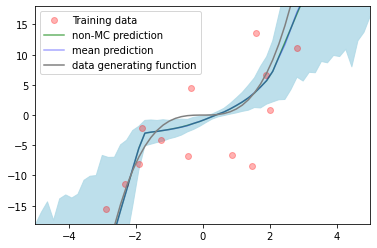

testing time = 0.6719999313354492 seconds

Mean = tensor([-3.3899e+01, -3.3985e+01, -3.3537e+01, -3.4415e+01, -3.3824e+01,
        -3.3147e+01, -3.3511e+01, -3.3890e+01, -3.3994e+01, -3.3783e+01,
        -3.3530e+01, -3.2913e+01, -3.3430e+01, -3.2916e+01, -3.3364e+01,
        -3.2409e+01, -3.2380e+01, -3.2430e+01, -3.2036e+01, -3.1648e+01,
        -3.1800e+01, -3.1971e+01, -3.2176e+01, -3.1210e+01, -3.1009e+01,
        -3.0499e+01, -3.0467e+01, -2.9621e+01, -2.8601e+01, -2.8078e+01,
        -2.6800e+01, -2.5607e+01, -2.3351e+01, -2.1796e+01, -1.9413e+01,
        -1.6338e+01, -1.4092e+01, -1.1369e+01, -9.0712e+00, -7.1227e+00,
        -5.3166e+00, -4.1407e+00, -3.0731e+00, -2.2727e+00, -1.7031e+00,
        -1.4462e+00, -1.3637e+00, -1.3112e+00, -1.0061e+00, -7.9682e-01,
        -3.9881e-01, -1.5454e-02,  4.8173e-01,  1.0536e+00,  1.6049e+00,
         2.2468e+00,  3.0197e+00,  3.7305e+00,  4.6611e+00,  5.5666e+00,
         6.5438e+00,  7.7238e+00,  8.5926e+00,  1.0291e+01,  1.1479e+01,
 

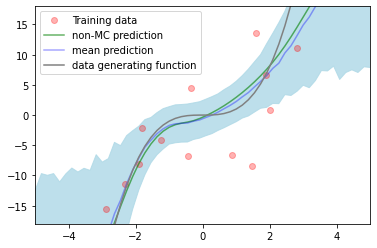

testing time = 0.6094691753387451 seconds

Mean = tensor([-41.0030, -41.4840, -40.5972, -40.8442, -40.6008, -40.0124, -40.4480,
        -40.2730, -39.5693, -38.7249, -39.3424, -38.5145, -38.6511, -38.3638,
        -37.5734, -37.9544, -36.9991, -36.1244, -35.3838, -36.1130, -34.5998,
        -34.3265, -34.3292, -31.4153, -32.0289, -30.9942, -29.9853, -28.8862,
        -27.4739, -26.4161, -24.8308, -23.4941, -22.0122, -19.8772, -18.1105,
        -16.6426, -14.9101, -12.8101, -11.4153,  -9.4915,  -7.7959,  -6.4760,
         -5.0051,  -3.6110,  -2.4709,  -1.3281,  -0.2887,   0.6753,   1.6684,
          2.4688,   3.3155,   4.1542,   4.8230,   5.7488,   6.5012,   7.2005,
          8.1592,   8.8928,   9.6333,  10.6572,  11.3096,  12.0913,  12.8465,
         13.9001,  14.6442,  14.8671,  15.8291,  16.7899,  17.2194,  18.1508,
         18.8089,  19.2855,  20.0198,  20.3726,  20.9741,  21.5313,  22.4044,
         22.7214,  23.4539,  23.7500,  24.6144,  25.2058,  24.5998,  25.3979,
         25.63

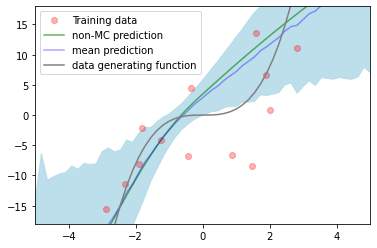

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()
    
    predictions_non_mc, _ = network(X_test)

    predictions, mean, var, metrics = network.predict_dist(
        X_test, n_predictions,
        y_test=y_test,
        reg_strength=reg_strength, train_size=dataset_toy_size, length_scale=length_scale)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for metric_key, value in metrics.items():
            print(str(metric_key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low-1, dataset_toy_x_high+1)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # Non-MC prediction
    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.6)    
    
    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean prediction', alpha=0.35)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=600)
    
    plt.show()